# Part 5: Time Series with Long Short Term Memory(LSTM) 
# &emsp; &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Recurrent Neural Network

<br>

In this part we will try to build and train Long Short Term Memory Recurrent Neural Network for our time series data. Let's first take a brief overview of LSTM.<br>

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (such as images), but also entire sequences of data (such as speech or video).<br>

Instead of neurons, LSTM networks have memory blocks that are connected through layers.
### Why LSTM for Time Series?
LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the exploding and vanishing gradient problems that can be encountered when training traditional RNNs.
<br><br>
We will use Keras with Tensorflow at backend for building our Neural Network.

In [1]:
# import necessary files
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error,  mean_absolute_error


Using TensorFlow backend.


### &emsp; &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Selecting Input and Output Shapes in LSTM
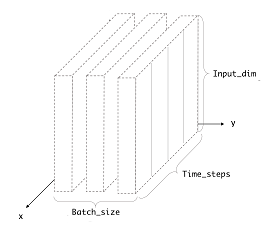
<br>
The input data to LSTM looks like the above diagram[[1]](https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e).<br><br>
<b>Note:</b> We always have to give a three-dimensional array as an input to your LSTM network. Where the first dimension represents the <b>batch size</b>, the second dimension represents the <b>time-steps</b> and the third dimension represents the <b>number of units</b> in one input sequence.
For example, the input shape looks like <b>(batch_size, time_steps, seq_len).

#### Designing the Architecture of  LSTM neural network

In [2]:
# Let's design the Architecture of our LSTM neural network
def fit_LSTM(scaled_train_data, time_steps, n_features, batch_size = 6, activation = 'relu', epochs = 10):
    ''''
        train_data: train data for training the model
        test_data: test data for evaluating the model
        activation: activation function. Default is 'relu'.
        return: lstm model

        Note:
        1) time_steps: 12 for monthly, 365 for daily data is preffered.
        2) batch size: let's keep batch size to any fixed size. We will fix it at 6.
    
    '''
    # define generator object to produce batches for training/validation.
    generator = TimeseriesGenerator(data = scaled_train_data, targets = scaled_train_data, length = time_steps, batch_size = batch_size)

    # Since we want to build LSTM network, In Keras we can simply stack multiple layers on top of each other,
    # for this we need to initialize the model as Sequential().
    model = Sequential()

    # add input layer. 
    #           units: We can take units as any no of dimensions(positive) for the outer space.
    #           activation: softmax, relu, softsign etc.
    model.add(LSTM(units = 200, activation = activation, input_shape = (time_steps, n_features)))

    # Dropout: Every LSTM layer should be accompanied by a Dropout layer.
    #          20% is often used as a good compromise between retaining model accuracy
    #          and preventing overfitting.
    model.add(Dropout(0.25))

    # add output layer the model. Since our model is making 
    # single predictions we'll take output layer as 1.
    model.add(Dense(1))
    # compile the model. Generally we use 'adam' optimiser. Let's take loss as mean square error. 
    model.compile(optimizer='adam', loss='mse')
    # fit the lstm neural network
    model.fit_generator(generator, epochs = epochs)
    
    return model

In [3]:
# function for predicting data for LSTM
def predict_LSTM(scaled_train_data, scaler, train_data, test_data, time_steps, n_features, lstm_model):
    '''
        scaled_train_data: scaled train data.
        scaler: MinMaxScaler object for inverting transformations.
        scaled_test_data:  scaled test data.
        train_data:  train data.
        test_data:   test data.
        time_steps: Time steps
        n_features: Number of units in one input sequence.
        lstm_model: The LSTM model to evaluate.
        return : Predicted values.
    '''
    # for storing predicted values.
    pred_list = []
    batch = scaled_train_data[-time_steps:].reshape(1, time_steps, n_features)
    for i in range(time_steps):
        pred_list.append(lstm_model.predict(batch)[0])
        batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis = 1)
        
    # creating dataframe of predicted values
    df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=test_data.index, columns = ['Predictions'])
    # plotting the results
    plt.figure(figsize = (20, 5))
    plt.plot(train_data.index, train_data, label = 'Train')
    plt.plot(test_data.index, test_data, label = 'Test')
    plt.plot(df_predict.index, df_predict, label = 'Prediction')
    plt.legend(loc='best', fontsize='xx-large')
    
    return df_predict

In [4]:
# function for evaluating the model
def evaluate_LSTM(actual, predicted):
    '''
        actual: actual values
        predicted: predicted values
        return: None
        
        calculates Mean square Error, Mean Absolute error and Root Mean Square Error
        
    '''
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    print('The Mean Squared Error of the forecasts is {}'.format(round(mse, 2)))
    print('The Mean Absolute Error of the forecasts is {}'.format(round(mae, 2)))
    print('The Root Mean Squared Error of the forecasts is {}'.format(np.sqrt(mse)))

In [5]:
# Scaling Train-Test data
def transform_data(train_data):
    '''
        train_data: Train data
        test_data: Test data
        return: (scaled_train_data, scaler)
    '''
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    
    return scaler.transform(train_data), scaler 

#### Applying LSTM to daily data of PM2.5
Let's first apply our LSTM model to daily data of PM2.5.

In [6]:
# loading the daily data of PM2.5
train_PM25 = pd.read_csv('dataset/daily/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('dataset/daily/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])

In order to feed our data into the neural network We need to first format our data into the specific format. Usually we scale data between either between (0,1) or (-1,1). We will use MinMaxScaler of scikitlearn library which will automatically scale the data.

In [7]:
# transform train_PM25 data
scaled_train_PM25, scaler = transform_data(train_PM25)

In [8]:
# define parameters for the LSTM model
# time_steps: 12 for monthly, 365 for daily data is preffered.
time_steps = 365
# no of units as n_feature: Since we have only one feature so we will take n_feature as 1.
n_feature = 1
# fit the LSTM model
model = fit_LSTM(scaled_train_PM25, time_steps, n_feature)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
122/122 [==============================] - 38s 311ms/step - loss: 0.0210
Epoch 2/10
122/122 [==============================] - 36s 297ms/step - loss: 0.0190
Epoch 3/10
122/122 [==============================] - 36s 295ms/step - loss: 0.0182
Epoch 4/10
122/122 [==============================] - 36s 298ms/step - loss: 0.0182
Epoch 5/10
122/122 [==============================] - 37s 302ms/step - loss: 0.0177
Epoch 6/10
122/122 [==============================] - 37s 301ms/step - loss: 0.0169
Epoch 7/10
122/122 [==============================] - 36s 299ms/step - loss: 0.0166
Epoch 8/10
122/122 [==============================] - 36s 297ms/step - loss: 0.0156
Epoch 9/10
122/122 [==============================] - 36s 298ms/step - loss: 0.0158
Epoch 10/

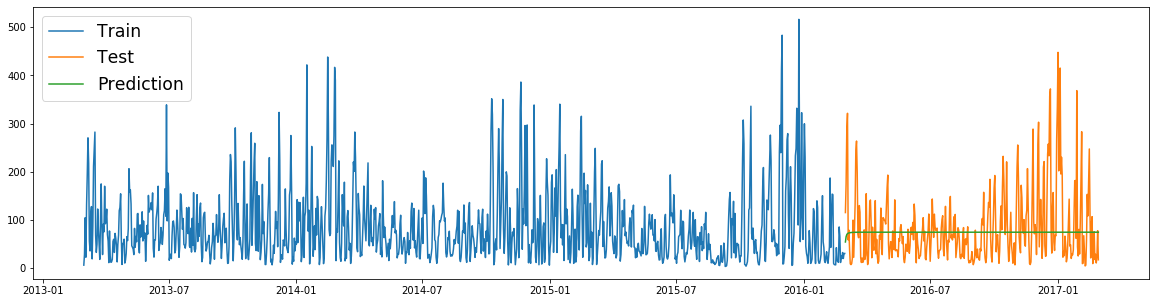

In [9]:
# Predict PM2.5 using LSTM
predictions = predict_LSTM(scaled_train_PM25, scaler, train_PM25, test_PM25,time_steps, n_feature, model)

In [10]:
# Plot the predictions for PM2.5 pollutant
evaluate_LSTM(test_PM25, predictions)

The Mean Squared Error of the forecasts is 5750.33
The Mean Absolute Error of the forecasts is 52.41
The Root Mean Squared Error of the forecasts is 75.83094405148877
